In [367]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# For Suppressing warnings
import warnings
warnings.filterwarnings('ignore')

# For Hopkins Statistics
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan

# Feature Scaling
from sklearn.preprocessing import StandardScaler

# For K Means
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# For Hierarchical Clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

plt.style.use("ggplot")

In [368]:
df=pd.read_csv('Country-data.csv')

In [369]:
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [370]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [371]:
df['country'].nunique()

167

In [372]:
df.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

In [373]:
df.duplicated().sum()

0

In [374]:
#convert exports, health,imports column which are represented as percentage of gdpp to actual values
#singe square backet is used to single column selection, multiple square brackets are used for multiple column selection.
df[['exports','imports','health']]=df[['exports','imports','health']].apply(lambda x:x*df['gdpp']/100)

In [375]:
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


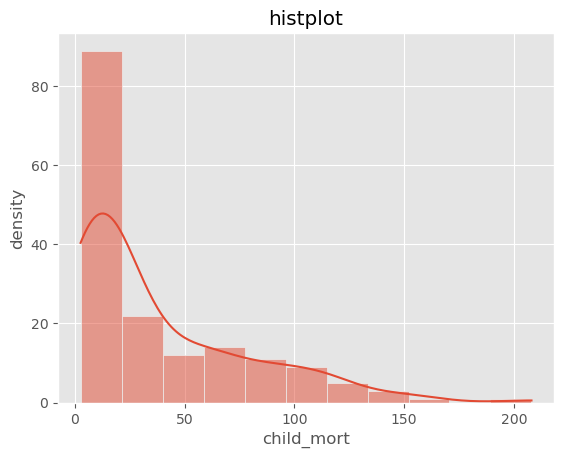

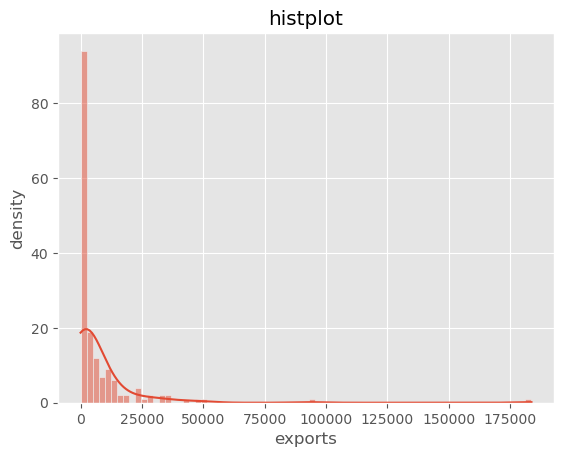

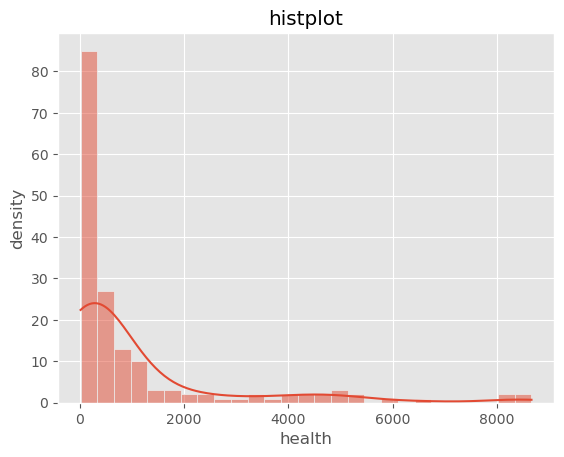

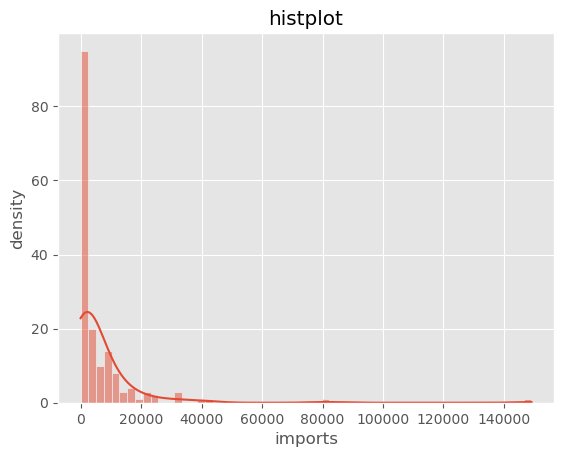

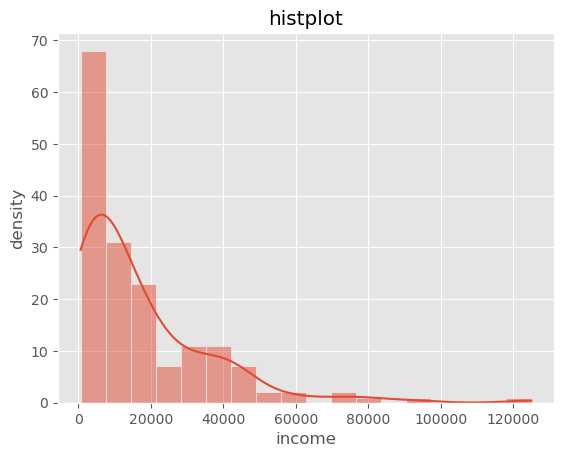

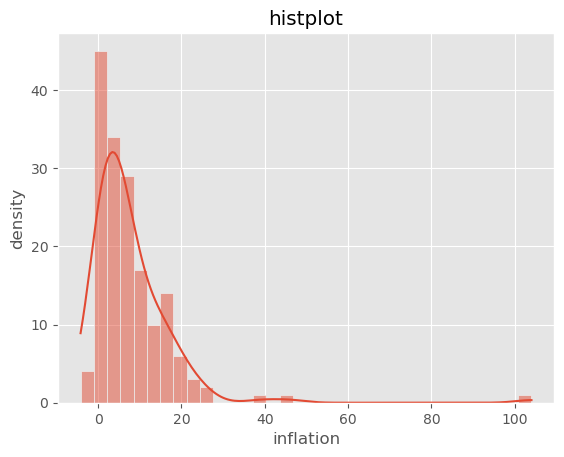

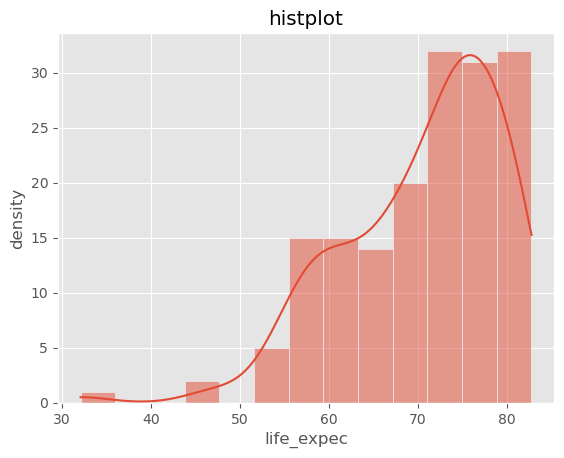

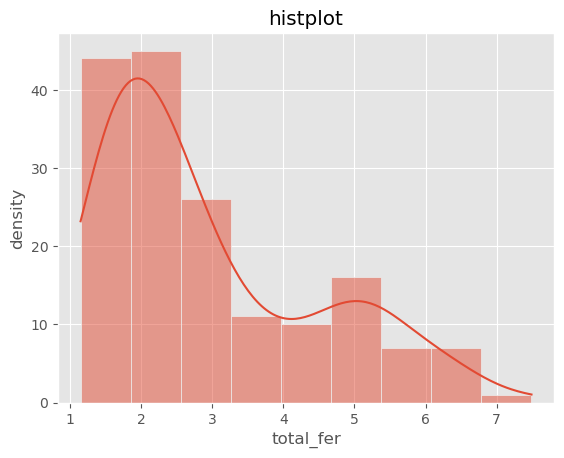

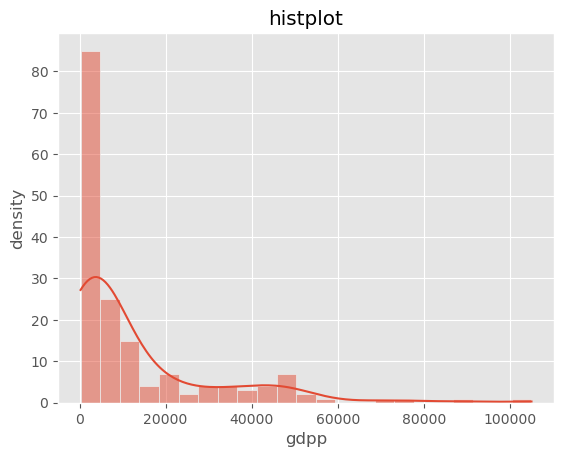

In [376]:
#Detect outleirs, but for detecting outliers we need to know the distribution of the data. for normally distributed data we use 
#z-score method, for skewed data we use iqr method for outlier detection and removal.
for col in df.drop('country',axis=1):
  plt.figure()
  sns.histplot(df[col],kde=True) #density gives the likehood of the data point to fall in that particular bin.(density*width gives the proportion of data).
  plt.title('histplot')
  plt.xlabel(col)
  plt.ylabel('density')

# plt.figure()
# sns.distplot(df['exports'],kde=True,bins=5) #density gives the likehood of the data point to fall in that particular bin.(density*width gives the proportion of data).
# plt.title('histogram')
# plt.xlabel(col)
# plt.ylabel('density')


we can see that the data is skewed in the distribution above, so if we want to remove outliers we can use IQR method.

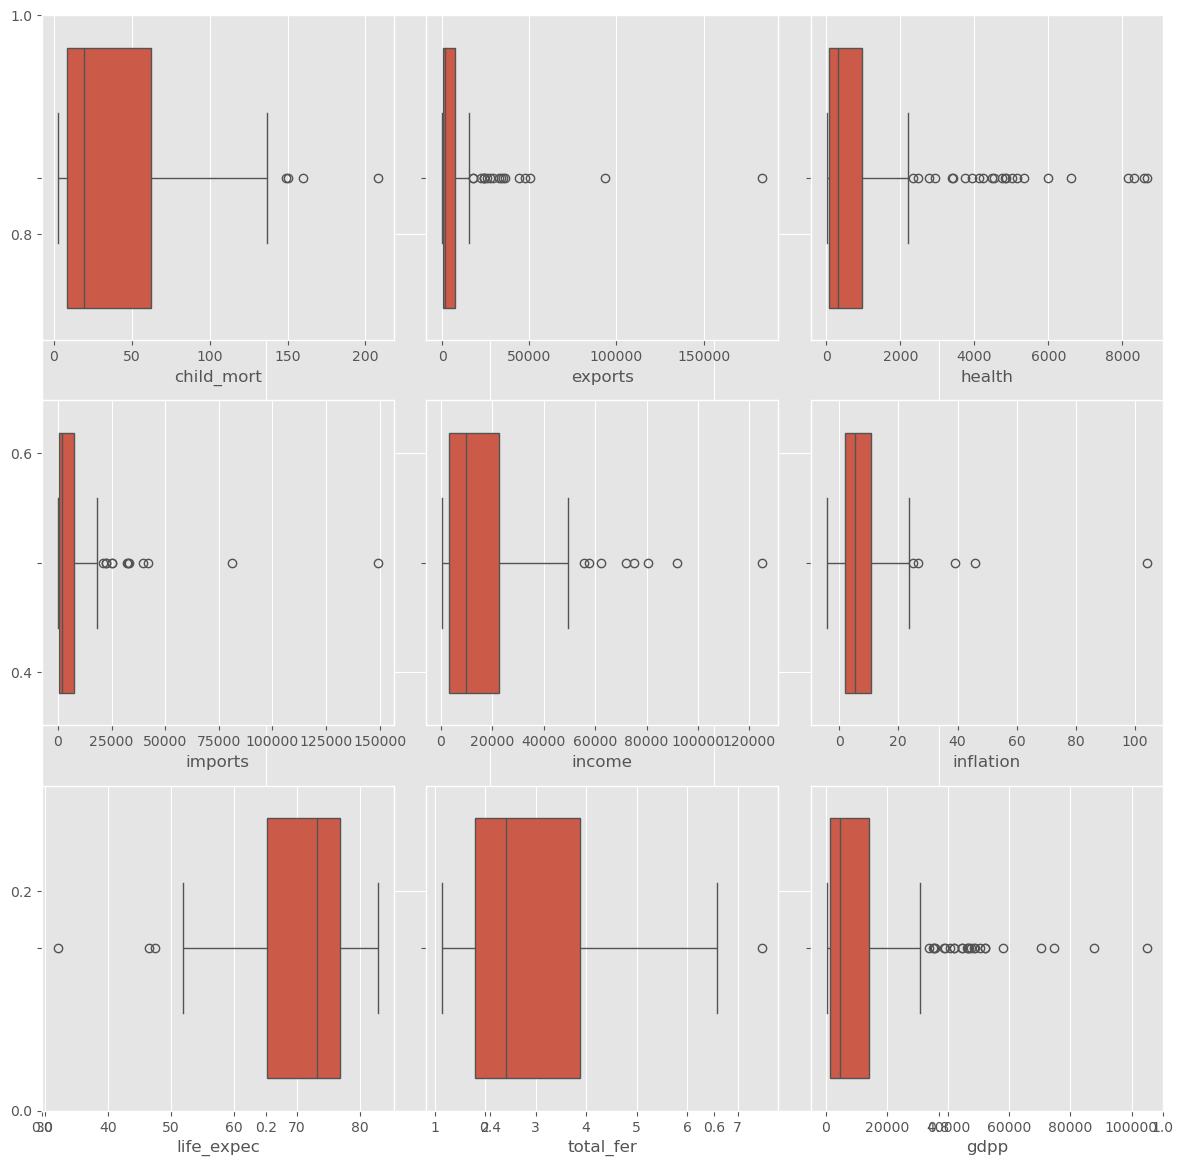

In [378]:
#lets plot the boxplot and check for outliers in each column except for country.
fig=plt.subplots(figsize=(12, 12))
for i, feature in enumerate(df.drop('country', axis=1).columns):
    plt.subplot(3, 3, i+1)
    plt.subplots_adjust(hspace = 2.0)
    sns.boxplot(x=df[feature])
    plt.tight_layout()

I am keeping 2 column without handling outliers as they may be useful in analysis.child_mort and ife_expec.
high child_mort rate will be seen in under developed countries due to poor nutrition or less health care or some other reasons.
similarly with the life_expec. These 2 may play crucial role in determining under developing countries.


In [380]:
#capping and flooring remaining features in the data frame.
for col in df.drop(columns=['country','child_mort','life_expec'],axis=1):
    Q1=df[col].quantile(0.25)
    Q3=df[col].quantile(0.75)
    IQR=Q3-Q1
    lowerBound=Q1-1.5*IQR
    upperBound=Q3+1.5*IQR
    df[col] = df[col].apply(lambda x: lowerBound if x < lowerBound else upperBound if x > upperBound else x)


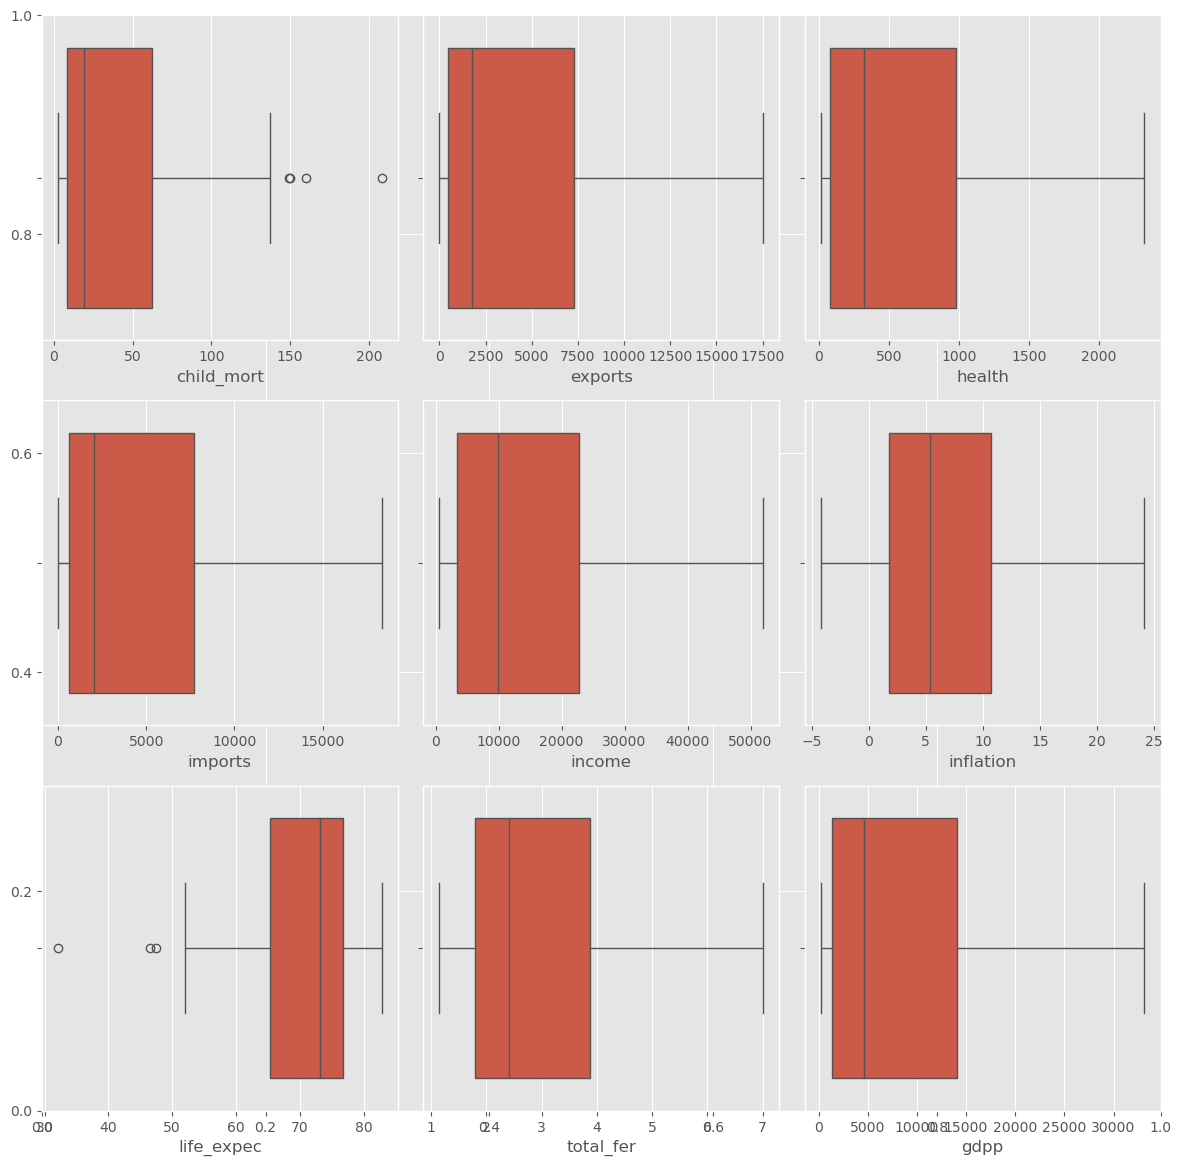

In [381]:
fig=plt.subplots(figsize=(12, 12))
for i, feature in enumerate(df.drop('country', axis=1).columns):
    plt.subplot(3, 3, i+1)
    plt.subplots_adjust(hspace = 2.0)
    sns.boxplot(x=df[feature])
    plt.tight_layout()

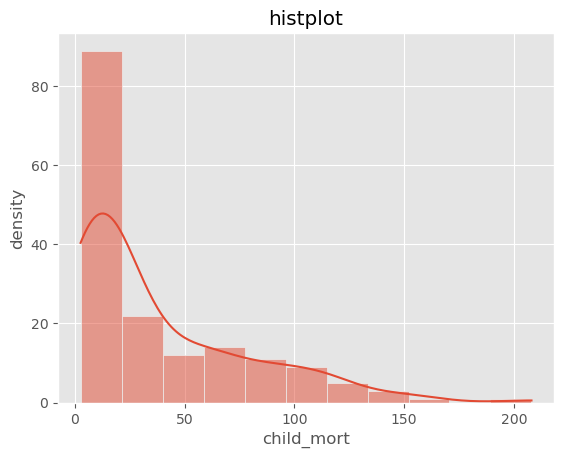

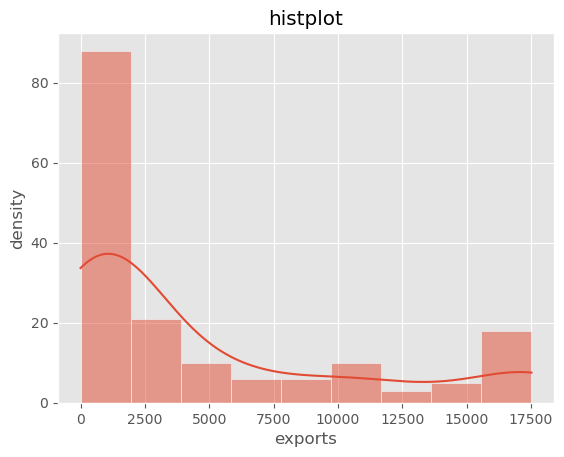

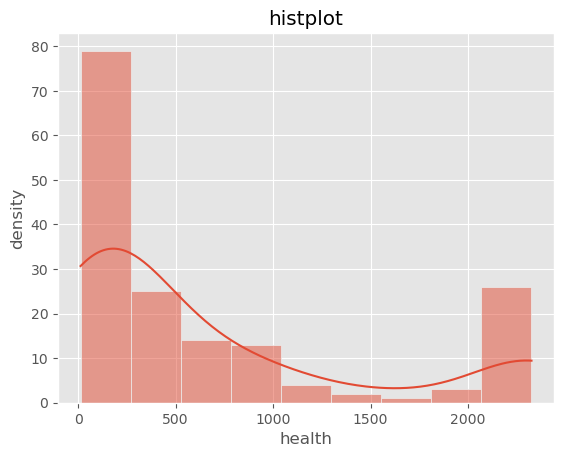

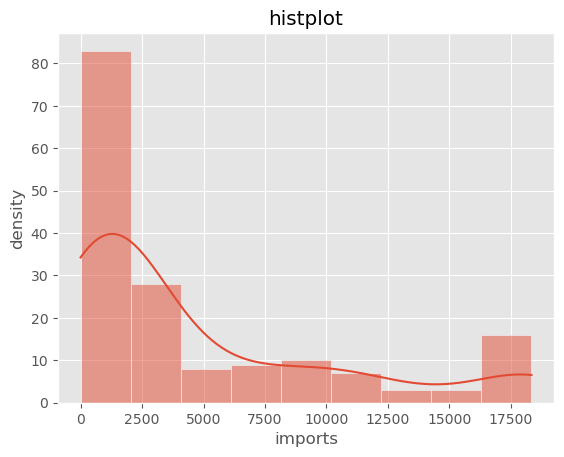

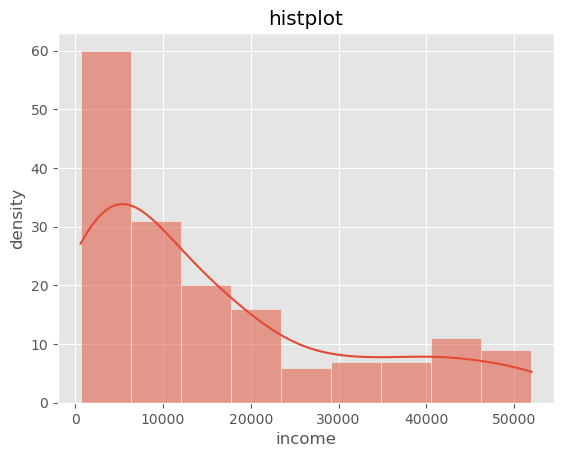

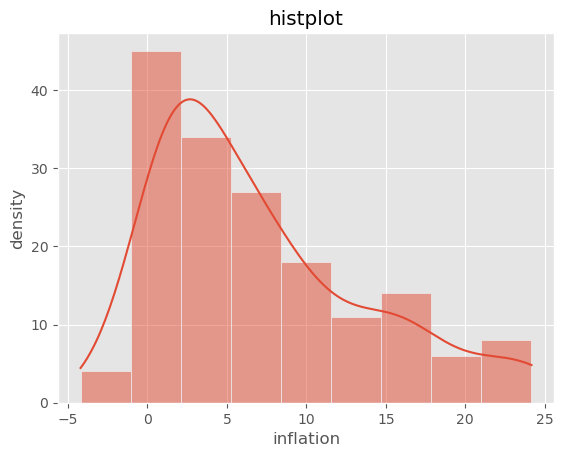

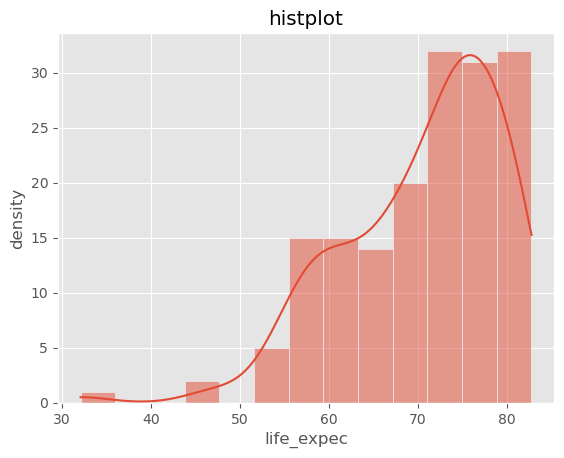

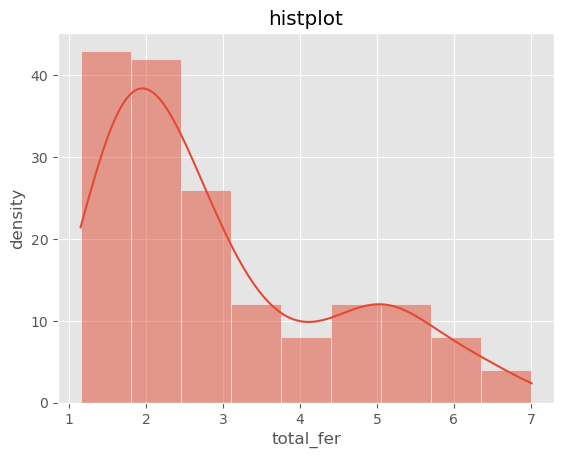

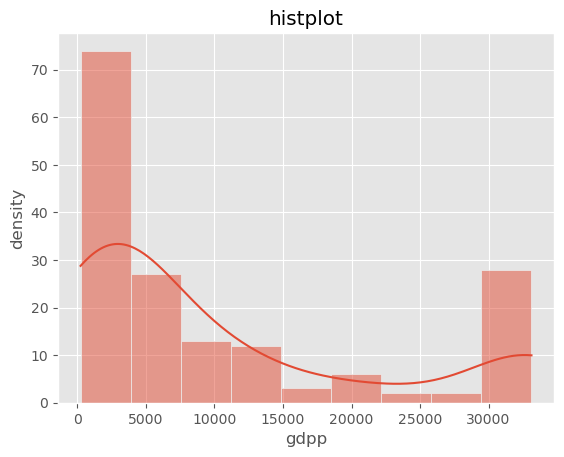

In [382]:
for col in df.drop('country',axis=1):
  plt.figure()
  sns.histplot(df[col],kde=True) #density gives the likehood of the data point to fall in that particular bin.(density*width gives the proportion of data).
  plt.title('histplot')
  plt.xlabel(col)
  plt.ylabel('density')

<Axes: >

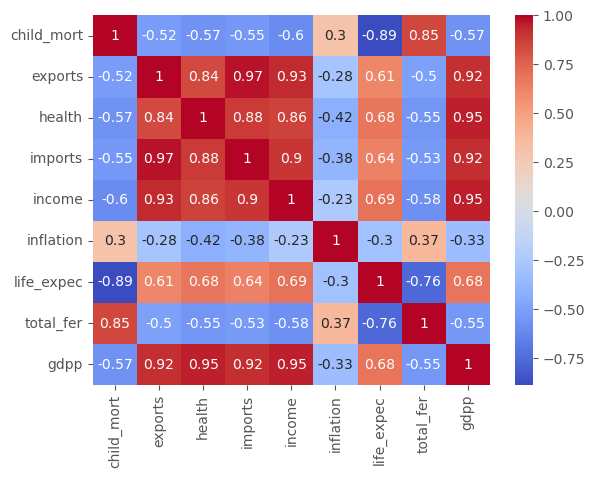

In [383]:
#check for multicollinearity between feaures
correlation_matrix=df.drop('country',axis=1).corr()
correlation_matrix
sns.heatmap(correlation_matrix,annot=True,cmap='coolwarm')


In [384]:
#do hopkins test to determine whether to apply clustering or not

def hopkins(X):
    n=len(X)
    m=int(0.1*n) #take random sample size
    d=X.shape[1]
    X_uniform=uniform(np.min(X,axis=0),np.max(X,axis=0),(m,d))
    X_sample=X.sample(m)
    nbrs=NearestNeighbors(n_neighbors=1).fit(X.values)
    # u_distances: distances of uniform points to the nearest real points
    u_distances, _ = nbrs.kneighbors(X_uniform, n_neighbors=1)
    
    # w_distances: distances of real points to the nearest real points
    w_distances, _ = nbrs.kneighbors(X_sample, n_neighbors=1)
    
    H = np.sum(u_distances) / (np.sum(u_distances) + np.sum(w_distances))
    
    return H

# Apply the Hopkins test to your data (assuming 'df' is your DataFrame)
hopkins_stat = hopkins(df.drop('country', axis = 1))
print(f"Hopkins Statistic: {hopkins_stat}")
    


Hopkins Statistic: 1.0


In [385]:
#the value represents need to clustering
#Scale data before applying clustering
updated_df=df
standard_scalar=StandardScaler()
df=standard_scalar.fit_transform(df.iloc[:,1:])


In [386]:
df #its numpy array now

array([[ 1.29153238, -0.80056371, -0.79556251, ..., -1.61909203,
         1.91527602, -0.84634107],
       [-0.5389489 , -0.61314982, -0.51391972, ...,  0.64786643,
        -0.86277926, -0.54082746],
       [-0.27283273, -0.51557561, -0.6160104 , ...,  0.67042323,
        -0.03669088, -0.50886816],
       ...,
       [-0.37231541, -0.64788476, -0.73612924, ...,  0.28695762,
        -0.66291917, -0.78095407],
       [ 0.44841668, -0.74249447, -0.76323195, ..., -0.34463279,
         1.14914567, -0.78095407],
       [ 1.11495062, -0.71718267, -0.7406285 , ..., -2.09278484,
         1.63547189, -0.7679976 ]])

clustering

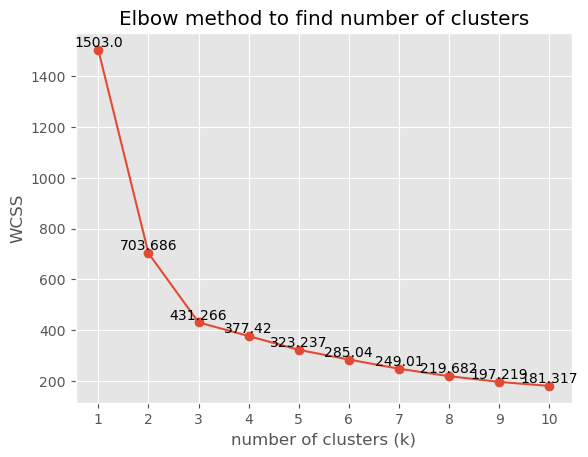

In [388]:
wcss=[]
for k in range(1,11):
    kmeans=KMeans(n_clusters=k,init='k-means++',n_init=10,max_iter=250,random_state=43)
    kmeans.fit(df)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss,marker='o')
plt.xticks(range(1,11))
plt.title("Elbow method to find number of clusters")
plt.xlabel("number of clusters (k)")
plt.ylabel("WCSS")
no_of_clusters=list(range(1,11))
for xy in zip(no_of_clusters, wcss):    
    plt.annotate(text=round(xy[1], 3), xy=xy, textcoords='data', 
                 ha='center', va='bottom')  # Corrected 's' to 'text'


The above elbow method in determining number of clusters. We need take the starting point from which the graph has stabilized which gives the optimal number of clusters. this is because, after that point there wont be much change in wcss. so we take k=3.

In [390]:
kmeans=KMeans(n_clusters=3,init='k-means++',n_init=10,max_iter=180,random_state=43)
kmeans.fit(df)

KMeans(max_iter=180, n_clusters=3, n_init=10, random_state=43)

In [391]:
print(kmeans.labels_)

[2 0 0 2 0 0 0 1 1 0 1 1 0 0 0 1 0 2 0 0 0 0 0 1 0 2 2 0 2 1 0 2 2 0 0 0 2
 2 2 0 2 0 1 1 1 0 0 0 0 2 2 1 0 1 1 2 2 0 1 2 1 0 0 2 2 0 2 1 1 0 0 0 2 1
 1 1 0 1 0 0 2 2 1 0 2 0 0 2 2 0 0 1 0 2 2 0 0 2 1 2 0 0 0 0 0 0 2 0 2 0 1
 1 2 2 1 1 2 0 0 0 0 0 1 1 0 0 2 0 1 2 0 0 2 1 1 1 2 0 1 1 0 0 2 0 1 1 0 2
 0 2 2 0 0 0 0 2 0 1 1 1 0 0 0 0 0 2 2]


In [392]:
print(kmeans.labels_.shape)

(167,)


In [393]:
kmeans_silhouette = silhouette_score(df, kmeans.labels_)
print("K-Means Silhouette Score:", kmeans_silhouette)

K-Means Silhouette Score: 0.43194297838941637


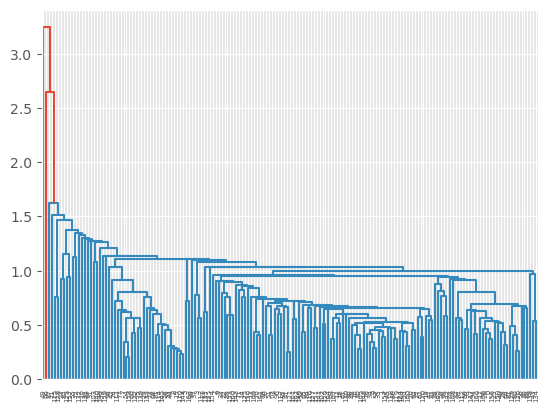

In [394]:
#Hierarchial clustering
mergings_single = linkage(df, method="single", metric='euclidean')
dendrogram(mergings_single)
plt.show()


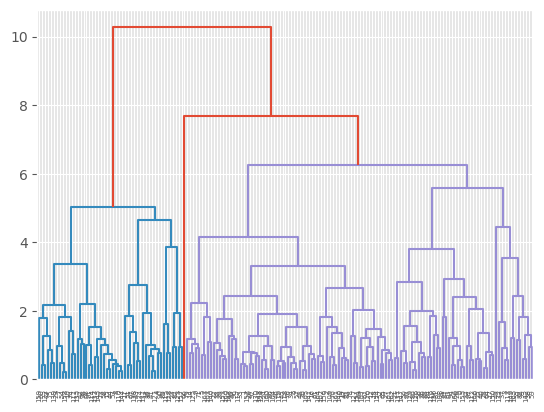

In [395]:
mergings_complete=linkage(df, method="complete", metric="euclidean")
dendrogram(mergings_complete)
plt.show()

In [396]:
cluster_labels = cut_tree(mergings_complete, n_clusters=3).reshape(-1, )
print(cluster_labels)
print(cluster_labels.shape)

[0 0 0 0 1 0 0 1 1 0 1 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0 0 2 1 1 0 0 0 0 1
 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1
 1 0 0 1 1 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 1 0 1 1 1 0 0 1 1 0 0 0 0 1 1 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0]
(167,)


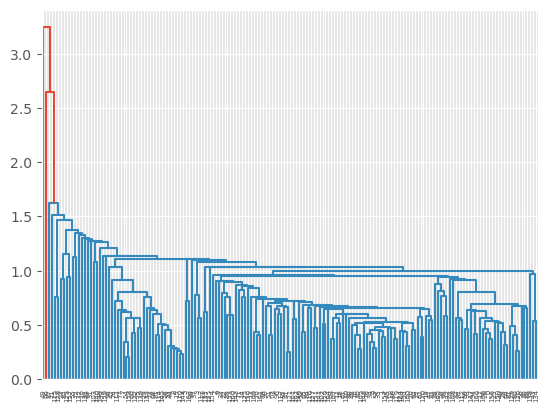

In [397]:
mergings_ward = linkage(df, method="ward", metric='euclidean')
dendrogram(mergings_single)
plt.show()


In [398]:
wardcluster_labels = cut_tree(mergings_ward, n_clusters=3).reshape(-1, )
print(wardcluster_labels)
print(wardcluster_labels.shape)

[0 1 1 0 1 1 1 2 2 1 2 2 0 1 1 2 1 0 0 0 1 0 1 2 1 0 0 0 0 2 1 0 0 1 1 1 0
 0 0 1 0 1 2 2 2 1 1 0 1 0 0 1 0 2 2 0 0 1 2 0 2 1 0 0 0 0 0 1 2 0 1 1 0 2
 2 2 1 2 1 1 0 0 2 0 0 1 1 0 0 1 1 2 1 0 0 1 1 0 2 0 1 0 1 1 1 1 0 0 0 1 2
 2 0 0 2 2 0 1 1 1 0 1 2 2 1 1 0 0 2 0 1 1 0 2 2 2 0 0 2 2 1 1 0 1 2 2 0 0
 1 0 0 0 1 1 0 0 1 2 2 2 1 1 0 1 1 0 0]
(167,)


In [399]:
from scipy.cluster.hierarchy import fcluster

hierarchical_labels = fcluster(mergings_ward, t=2, criterion='maxclust')
hierarchical_silhouette = silhouette_score(df, hierarchical_labels) 
print("Hierarchical Clustering Silhouette Score:", hierarchical_silhouette)

Hierarchical Clustering Silhouette Score: 0.5062987137899394


when the method is ward we can see silhouette score is high and divides in to 3 clusters.

In [401]:
#df_updated = pd.DataFrame(df)
df_clustered = updated_df.iloc[:,:]
df_clustered = pd.concat([df_clustered, pd.DataFrame(kmeans.labels_, columns=['cluster_id_km'])], axis = 1)
df_clustered = pd.concat([df_clustered, pd.DataFrame(wardcluster_labels, columns=['cluster_id_hc'])], axis = 1)
df_clustered.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id_km,cluster_id_hc
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,2,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,0,1
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,0,1
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,2,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,0,1


In [402]:
print(df_clustered['cluster_id_km'].value_counts())
print(df_clustered['cluster_id_hc'].value_counts())

cluster_id_km
0    80
2    46
1    41
Name: count, dtype: int64
cluster_id_hc
0    66
1    62
2    39
Name: count, dtype: int64


In [403]:
print("Cluster 0 of Hierarchical Clustering model")
print(df_clustered[df_clustered['cluster_id_hc'] == 0].country.unique())

print("Cluster 1 of Hierarchical Clustering model")
print(df_clustered[df_clustered['cluster_id_hc'] == 1].country.unique())

print("Cluster 2 of Hierarchical Clustering model")
print(df_clustered[df_clustered['cluster_id_hc'] == 2].country.unique())

Cluster 0 of Hierarchical Clustering model
['Afghanistan' 'Angola' 'Bangladesh' 'Benin' 'Bhutan' 'Bolivia' 'Botswana'
 'Burkina Faso' 'Burundi' 'Cambodia' 'Cameroon' 'Central African Republic'
 'Chad' 'Comoros' 'Congo, Dem. Rep.' 'Congo, Rep.' "Cote d'Ivoire" 'Egypt'
 'Equatorial Guinea' 'Eritrea' 'Fiji' 'Gabon' 'Gambia' 'Ghana' 'Guatemala'
 'Guinea' 'Guinea-Bissau' 'Guyana' 'Haiti' 'India' 'Iraq' 'Kenya'
 'Kiribati' 'Kyrgyz Republic' 'Lao' 'Lesotho' 'Liberia' 'Madagascar'
 'Malawi' 'Mali' 'Mauritania' 'Micronesia, Fed. Sts.' 'Mozambique'
 'Myanmar' 'Namibia' 'Niger' 'Nigeria' 'Pakistan' 'Philippines' 'Rwanda'
 'Samoa' 'Senegal' 'Sierra Leone' 'Solomon Islands' 'South Africa' 'Sudan'
 'Tajikistan' 'Tanzania' 'Timor-Leste' 'Togo' 'Tonga' 'Turkmenistan'
 'Uganda' 'Vanuatu' 'Yemen' 'Zambia']
Cluster 1 of Hierarchical Clustering model
['Albania' 'Algeria' 'Antigua and Barbuda' 'Argentina' 'Armenia'
 'Azerbaijan' 'Barbados' 'Belarus' 'Belize' 'Bosnia and Herzegovina'
 'Brazil' 'Bulgaria' 'C

In [439]:
print("Cluster 0 of kmeans Clustering model")
print(df_clustered[df_clustered['cluster_id_km'] == 0].country.unique())

print("Cluster 1 of kmeans Clustering model")
print(df_clustered[df_clustered['cluster_id_km'] == 1].country.unique())

print("Cluster 2 of kmeans Clustering model")
print(df_clustered[df_clustered['cluster_id_km'] == 2].country.unique())

Cluster 0 of kmeans Clustering model
['Albania' 'Algeria' 'Antigua and Barbuda' 'Argentina' 'Armenia'
 'Azerbaijan' 'Bangladesh' 'Barbados' 'Belarus' 'Belize' 'Bhutan'
 'Bolivia' 'Bosnia and Herzegovina' 'Botswana' 'Brazil' 'Bulgaria'
 'Cambodia' 'Cape Verde' 'Chile' 'China' 'Colombia' 'Costa Rica' 'Croatia'
 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Fiji' 'Georgia'
 'Grenada' 'Guatemala' 'Guyana' 'India' 'Indonesia' 'Iran' 'Jamaica'
 'Jordan' 'Kazakhstan' 'Kyrgyz Republic' 'Latvia' 'Lebanon' 'Libya'
 'Lithuania' 'Macedonia, FYR' 'Malaysia' 'Maldives' 'Mauritius'
 'Micronesia, Fed. Sts.' 'Moldova' 'Mongolia' 'Montenegro' 'Morocco'
 'Myanmar' 'Nepal' 'Panama' 'Paraguay' 'Peru' 'Philippines' 'Poland'
 'Romania' 'Russia' 'Samoa' 'Serbia' 'Seychelles' 'South Africa'
 'Sri Lanka' 'St. Vincent and the Grenadines' 'Suriname' 'Tajikistan'
 'Thailand' 'Tonga' 'Tunisia' 'Turkey' 'Turkmenistan' 'Ukraine' 'Uruguay'
 'Uzbekistan' 'Vanuatu' 'Venezuela' 'Vietnam']
Cluster 1 of kmeans Clus

In hierarchical: 0-underdeveloped, 1-developing, 2-developed
In kmeans: 0-developing,1-developed, 2-underdeveloped
so financia aid must be given to underdeveloped countries.

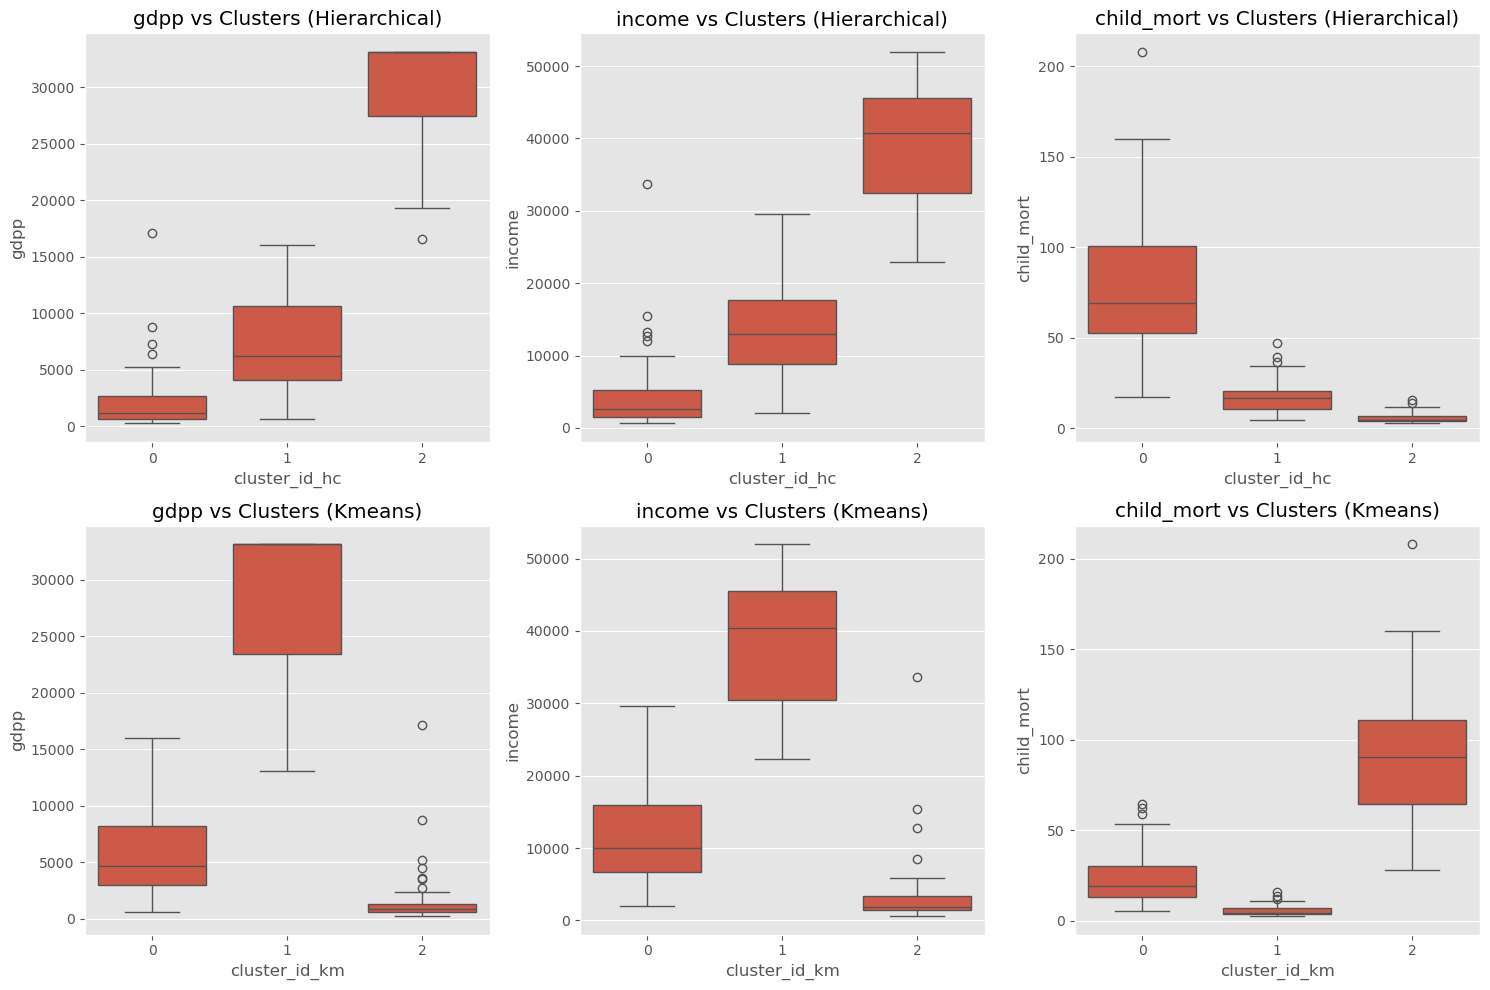

In [445]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_clustered is a DataFrame with columns 'cluster_id_hc', 'cluster_id_km', 'gdpp', and 'income'
fig = plt.figure(figsize=(15, 10))

ax1 = fig.add_subplot(2, 3, 1, title="gdpp vs Clusters (Hierarchical)")
ax4 = fig.add_subplot(2, 3, 4, title="gdpp vs Clusters (Kmeans)")

ax2 = fig.add_subplot(2, 3, 2, title="income vs Clusters (Hierarchical)")
ax5 = fig.add_subplot(2, 3, 5, title="income vs Clusters (Kmeans)")

ax3 = fig.add_subplot(2, 3, 3, title="child_mort vs Clusters (Hierarchical)")
ax6 = fig.add_subplot(2, 3, 6, title="child_mort vs Clusters (Kmeans)")

# Use keyword arguments for x and y
sns.boxplot(x='cluster_id_hc', y='gdpp', data=df_clustered, ax=ax1)
sns.boxplot(x='cluster_id_km', y='gdpp', data=df_clustered, ax=ax4)

sns.boxplot(x='cluster_id_hc', y='income', data=df_clustered, ax=ax2)
sns.boxplot(x='cluster_id_km', y='income', data=df_clustered, ax=ax5)

sns.boxplot(x='cluster_id_hc', y='child_mort', data=df_clustered, ax=ax3)
sns.boxplot(x='cluster_id_km', y='child_mort', data=df_clustered, ax=ax6)

plt.tight_layout()
plt.show()


In [447]:
df_clustered.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id_km,cluster_id_hc
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,2,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,0,1
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,0,1
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,2,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,0,1


In [451]:
# Final list of under-developed countries, in order of socio-economic condition from worst to better -


df_clustered[(df_clustered['cluster_id_hc']==0)].sort_values(by=['gdpp', 'income', 'child_mort'], ascending=[True, True, False])[['country']].head(15)


,country
26,Burundi
88,Liberia
37,"Congo, Dem. Rep."
112,Niger
132,Sierra Leone
93,Madagascar
106,Mozambique
31,Central African Republic
94,Malawi
50,Eritrea
